In [1]:
import matplotlib.pyplot as plt
import importlib.util
import pandas as pd
import numpy as np
import h5py
import tables
import tensorflow as tf
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable
from crashpy.dataclasses.simulation import LoadedSimulation as Sim
from get_spectrum import get_spectra

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell

# pretty print all cell's output and not just the last one
InteractiveShell.ast_node_interactivity = "all"
import illustris_python as il

In [113]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

In [24]:
basePath = '/virgo/simulations/IllustrisTNG/L35n2160TNG/output'
fields = ['GroupMass']
h = 0.6774
mass_norm =  1e10
all_masses = il.groupcat.loadHalos(basePath,13,fields=['GroupMass','GroupMassType'])

In [90]:
il.groupcat.loadHalos(basePath,13,fields='GroupMassType')[:,4].shape

(11455631,)

In [28]:
halo_mass = all_masses['GroupMass']/h*mass_norm
star_mass = all_masses['GroupMassType'][:,4]/h*mass_norm
dm_mass =  all_masses['GroupMassType'][:,1]/h*mass_norm

In [93]:
il.groupcat.loadHeader(basePath,8)

{'BoxSize': 35000.0,
 'FlagDoubleprecision': 0,
 'Git_commit': b'd203ec8b07c7e2bdda5f608aa0babea46d603699',
 'Git_date': b'Thu Apr 7 14:14:27 2016 +0200',
 'HubbleParam': 0.6774,
 'Ngroups_ThisFile': 9345,
 'Ngroups_Total': 8454982,
 'Nids_ThisFile': 2115755,
 'Nids_Total': 1275248686,
 'Nsubgroups_ThisFile': 10733,
 'Nsubgroups_Total': 6797991,
 'NumFiles': 680,
 'Omega0': 0.3089,
 'OmegaLambda': 0.6911,
 'Redshift': 8.012172948865935,
 'Time': 0.11096103078290759}

In [87]:
box_size = 35

In [ ]:
def get_median_escape(df, edges, mass_type):
    means = []
    error = []
    centers = []
    variance = []
    for i in range(len(edges)-1):
        sub_fesc = df[(edges[i]*(1-1e-10)<df[halo_prop]) & (df[halo_prop]<edges[i+1])]['f_esc']
        centers.append(np.exp((np.log(edges[i+1])+np.log(edges[i]))/2.))
        
        if mode == 'median':
            means.append(sub_fesc.median())
        elif mode == 'mean':
            means.append(sub_fesc.mean())
    
        error.append(sub_fesc.std()/np.sqrt(sub_fesc.shape[0]))
        variance.append(sub_fesc.var())
    

In [101]:
def get_tng_masses(mass_type, snap):
    basePath = '/virgo/simulations/IllustrisTNG/L35n2160TNG/output'
    h = 0.6774
    if mass_type == 'StarMass':
        mass_norm = 1e4
        masses = il.groupcat.loadHalos(basePath,snap,fields='GroupMassType')[:,4]/h*mass_norm
    elif mass_type == 'HaloMass':
        masses = il.groupcat.loadHalos(basePath,snap,fields='GroupMass')/h
    else:
        raise ValueError(f'"mass_type" has to be "StarMass" or "GroupMass" received {mass_type} instead')
    return masses

In [106]:
def get_halos_per_bin(df, redshift, bins=30, mass_type='StarMass'):
    redshift_map = {6:13, 8:8, 10:4}
    box_size=35.
    tng_masses = get_tng_masses(mass_type, snap=redshift_map[redshift])
    mass_min = df[df.z==redshift][mass_type].min()
    mass_max = df[df.z==redshift][mass_type].max()
    masses_cut = tng_masses[(tng_masses>mass_min)*(tng_masses<mass_max)]
    
    edges = np.logspace(mass_min,mass_max, bins)
    centroids = []
    widths = []
    for i in range(len(edges)-1):
        centroids.append(edges[i]/2+edges[i+1]/2)
        widths.append(edges_star[i+1]-edges_star[i])
    centroids = np.array(centroids)
    widths = np.array(widths)
    hist, _ = np.histogram(masses_cut, bins=edges)
    hist_norm = hist/box_size**3
    
    print(masses_cut.min())
    print(masses_cut.max())
    print(masses_cut.shape)

In [108]:
get_halos_per_bin(df_no_dust, redshift=8)

0.68631166
392.3264
(31172,)


In [109]:
get_halos_per_bin(df_no_dust, redshift=10)

0.6784866
262.65918
(14759,)


In [107]:
get_halos_per_bin(df_no_dust, redshift=6)

0.6785585
697.2953
(56928,)


In [7]:
def update_df(df):
    #df.set_index('ID', inplace=True)
    df['Q0/HaloMass']=df['Q0']/df['HaloMass']
    df['R_v^3/HaloMass']=df['HaloRadii']**3/df['HaloMass']
    df['StarMass']= df['HaloMass']*df['FractionStars']*1e4
    return

In [98]:
df_no_dust = pd.read_hdf('df_f_esc_freq.h5', 'no_dust')
update_df(df_no_dust)

In [85]:
df_no_dust.StarMass.max()

697.41390645504

In [86]:
df_no_dust.StarMass.min()

0.6784678407711908

In [46]:
bins=40
edges = np.logspace(np.log10(halo_mass.min()),np.log10(halo_mass.max()), bins)
edges_star = np.logspace(np.log10(star_mass[star_mass != 0].min()),np.log10(star_mass.max()), bins)

In [47]:
centroids = []
for i in range(len(edges)-1):
    centroids.append(edges_star[i]/2+edges_star[i+1]/2)
centroids = np.array(centroids)

In [88]:
hist, _ = np.histogram(star_mass, bins=edges_star)
hist_norm = hist/box_size**3

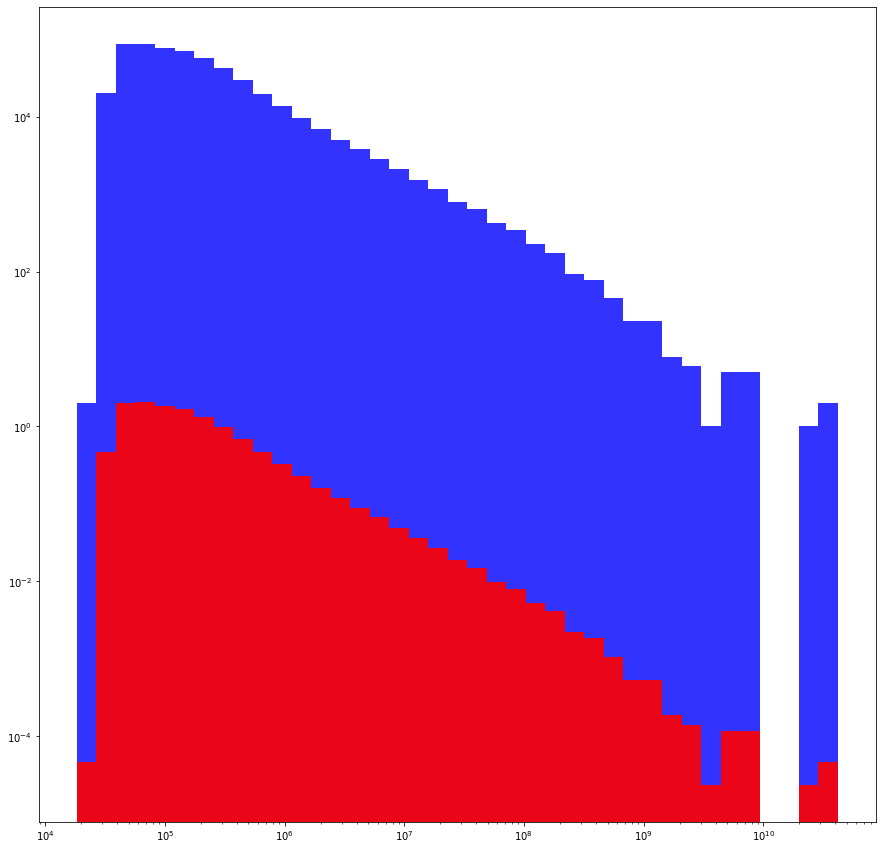

In [89]:
_ = plt.hist(star_mass, bins=edges_star, color = 'blue', alpha=0.8)
plt.bar(centroids,hist_norm, width=widths, alpha=0.9, color='red')
plt.yscale('log')
plt.xscale('log')
plt.rcParams["figure.figsize"] = (15,15);

In [80]:
widths = []
for i in range(len(edges_star)-1):
    widths.append(edges_star[i+1]-edges_star[i])
widths = np.array(widths)
print(centroids)

[2.26432681e+04 3.29578363e+04 4.79709452e+04 6.98228963e+04
 1.01628951e+05 1.47923450e+05 2.15306237e+05 3.13383549e+05
 4.56137501e+05 6.63919405e+05 9.66351102e+05 1.40654791e+06
 2.04726525e+06 2.97984516e+06 4.33723827e+06 6.31295749e+06
 9.18866565e+06 1.33743299e+07 1.94666677e+07 2.83342160e+07
 4.12411516e+07 6.00275154e+07 8.73715322e+07 1.27171424e+08
 1.85101151e+08 2.69419300e+08 3.92146449e+08 5.70778848e+08
 8.30782719e+08 1.20922478e+09 1.76005655e+09 2.56180581e+09
 3.72877166e+09 5.42731930e+09 7.89959738e+09 1.14980592e+10
 1.67357093e+10 2.43592385e+10 3.54554737e+10]


In [73]:
hist.shape
centroids.shape
widths.shape

(39,)

(39,)

(39,)

In [79]:
print(hist)
print(widths)
centroids
edges

[    2 20303 86836 88181 78492 71245 57082 42177 29782 20020 13859  9699
  6938  5045  3797  2889  2108  1534  1152   796   636   425   341   226
   175    94    78    45    23    23     8     6     1     5     5     0
     0     1     2]
[1.03527883e+06 1.44134946e+06 2.00669445e+06 2.79378646e+06
 3.88960201e+06 5.41523270e+06 7.53926627e+06 1.04964161e+07
 1.46134581e+07 2.03453402e+07 2.83254563e+07 3.94356381e+07
 5.49036012e+07 7.64386115e+07 1.06420366e+08 1.48161957e+08
 2.06275982e+08 2.87184252e+08 3.99827425e+08 5.56652980e+08
 7.74990710e+08 1.07896773e+09 1.50217460e+09 2.09137721e+09
 2.91168460e+09 4.05374371e+09 5.64375621e+09 7.85742427e+09
 1.09393662e+10 1.52301479e+10 2.12039162e+10 2.95207942e+10
 4.10998271e+10 5.72205401e+10 7.96643306e+10 1.10911319e+11
 1.54414410e+11 2.14980855e+11 2.99303464e+11]


array([2.26432681e+04, 3.29578363e+04, 4.79709452e+04, 6.98228963e+04,
       1.01628951e+05, 1.47923450e+05, 2.15306237e+05, 3.13383549e+05,
       4.56137501e+05, 6.63919405e+05, 9.66351102e+05, 1.40654791e+06,
       2.04726525e+06, 2.97984516e+06, 4.33723827e+06, 6.31295749e+06,
       9.18866565e+06, 1.33743299e+07, 1.94666677e+07, 2.83342160e+07,
       4.12411516e+07, 6.00275154e+07, 8.73715322e+07, 1.27171424e+08,
       1.85101151e+08, 2.69419300e+08, 3.92146449e+08, 5.70778848e+08,
       8.30782719e+08, 1.20922478e+09, 1.76005655e+09, 2.56180581e+09,
       3.72877166e+09, 5.42731930e+09, 7.89959738e+09, 1.14980592e+10,
       1.67357093e+10, 2.43592385e+10, 3.54554737e+10])

array([2.63944782e+06, 3.67472665e+06, 5.11607611e+06, 7.12277056e+06,
       9.91655702e+06, 1.38061590e+07, 1.92213917e+07, 2.67606580e+07,
       3.72570741e+07, 5.18705322e+07, 7.22158724e+07, 1.00541329e+08,
       1.39976967e+08, 1.94880568e+08, 2.71319180e+08, 3.77739545e+08,
       5.25901502e+08, 7.32177485e+08, 1.01936174e+09, 1.41918916e+09,
       1.97584214e+09, 2.75083285e+09, 3.82980058e+09, 5.33197517e+09,
       7.42335238e+09, 1.03350370e+10, 1.43887807e+10, 2.00325369e+10,
       2.78899612e+10, 3.88293274e+10, 5.40594753e+10, 7.52633914e+10,
       1.04784186e+11, 1.45884013e+11, 2.03104553e+11, 2.82768883e+11,
       3.93680202e+11, 5.48094612e+11, 7.63075467e+11, 1.06237893e+12])

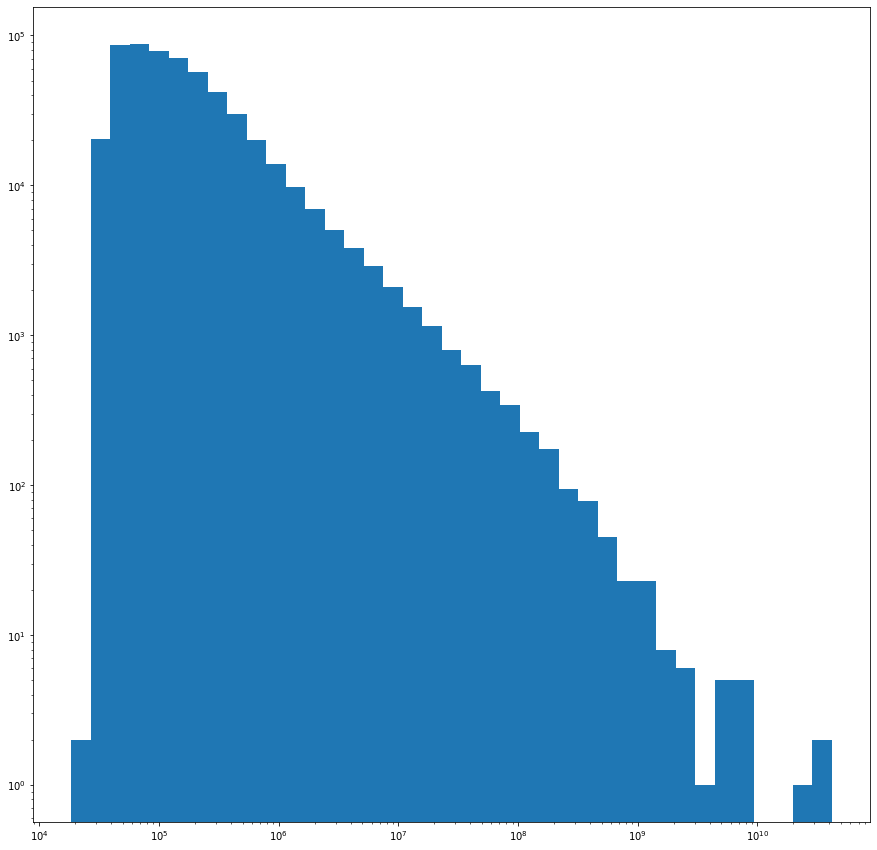

In [81]:
plt.bar(centroids,hist, width=widths)
plt.yscale('log')
plt.xscale('log')
plt.rcParams["figure.figsize"] = (15,15);